In [2]:
# !pip install tciaclient pydicom matplotlib numpy
import os
import zipfile
from tqdm import tqdm
from pathlib import Path
from tciaclient.core import TCIAClient
import matplotlib.pyplot as plt
import pydicom
import numpy as np


client = TCIAClient()


In [3]:
# Set constants
COLLECTION = "RIDER Lung CT"
DATA_DIR = Path("/mnt/tcia_data/raw") / COLLECTION
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Initialize TCIA API client
client = TCIAClient()

# List all patients in the collection
patients = client.get_patient(collection=COLLECTION)
print(f"Found {len(patients)} patients.")

# Optional: preview a few
for p in patients[:3]:
    print("-", p["PatientID"])

Found 64 patients.
- RIDER-1129164940
- RIDER-1129164940
- RIDER-1225316081


In [4]:
# Pick first patient
PATIENT_ID = patients[1]["PatientID"]

# Get studies
studies = client.get_patient_study(collection=COLLECTION, patientId=PATIENT_ID)
print(f"Found {len(studies)} studies for patient {PATIENT_ID}")
for s in studies:
    print("-", s["StudyInstanceUID"])

# Get CT series from the first study
STUDY_UID = studies[0]["StudyInstanceUID"]
series_list = client.get_series(collection=COLLECTION, studyInstanceUid=STUDY_UID, modality="CT")
print(f"Found {len(series_list)} CT series in study {STUDY_UID}")

for s in series_list:
    desc = s.get("SeriesDescription", "[No Description]")
    print("-", desc, "| UID:", s["SeriesInstanceUID"])

Found 18 studies for patient RIDER-1129164940
- 1.3.6.1.4.1.9328.50.1.216116555221814778114703363464001196508
- 1.2.276.0.7230010.3.1.2.1565948079.2848.1345144152.475
- 1.2.276.0.7230010.3.1.2.505801377.3020.1345983492.611
- 1.2.276.0.7230010.3.1.2.1231426215.1548.1345734062.488
- 1.2.276.0.7230010.3.1.2.4148549909.1376.1344859631.573
- 1.2.276.0.7230010.3.1.2.1231426215.1056.1345551432.403
- 1.3.6.1.4.1.14519.5.2.1.295526028989915648257590762384148204592
- 1.3.6.1.4.1.14519.5.2.1.216887537006644446680797968072501840065
- 1.3.6.1.4.1.14519.5.2.1.143105562673914638086740723575109688216
- 1.3.6.1.4.1.9328.50.1.216116555221814778114703363464001196508
- 1.2.276.0.7230010.3.1.2.1565948079.2848.1345144152.475
- 1.2.276.0.7230010.3.1.2.505801377.3020.1345983492.611
- 1.2.276.0.7230010.3.1.2.1231426215.1548.1345734062.488
- 1.2.276.0.7230010.3.1.2.4148549909.1376.1344859631.573
- 1.2.276.0.7230010.3.1.2.1231426215.1056.1345551432.403
- 1.3.6.1.4.1.14519.5.2.1.2955260289899156482575907623841482

Previewing series: /mnt/tcia_data/raw/RIDER Lung CT/RIDER-1129164940/1.3.6.1.4.1.14519.5.2.1.252069423416006466460547359547940119919
Images stacked: (117, 512, 512)


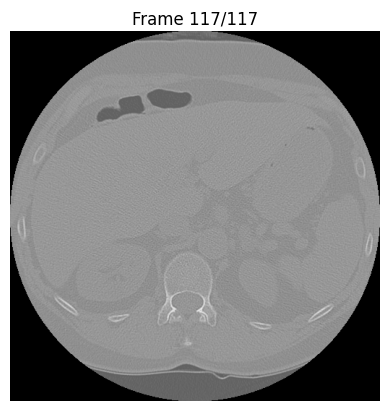

In [5]:

# Set the patient and (optionally) series directory
PATIENT_DIR = Path("/mnt/tcia_data/raw/RIDER Lung CT/RIDER-1129164940")
# List all series folders
series_folders = [f for f in PATIENT_DIR.iterdir() if f.is_dir()]

# Pick the first series to preview (customize as needed)
SERIES_DIR = series_folders[1]
print(f"Previewing series: {SERIES_DIR}")

# Gather all DICOM file paths
dicom_files = sorted(SERIES_DIR.glob("*.dcm"))
if not dicom_files:
    # Sometimes DICOMs are in subfolders; scan recursively
    dicom_files = sorted(SERIES_DIR.rglob("*.dcm"))

# Load and stack all slices
slices = [pydicom.dcmread(str(f)) for f in dicom_files]
# For many 4DCTs, each file is one (slice, phase). You may need to group by InstanceNumber or ImagePositionPatient.
slices = sorted(slices, key=lambda x: (int(x.InstanceNumber), getattr(x, "PhaseNumber", 0)))
images = np.stack([s.pixel_array for s in slices])

print(f"Images stacked: {images.shape}")

# Show as animation (scroll through or animate)
import matplotlib.animation as animation

fig, ax = plt.subplots()
im = ax.imshow(images[0], cmap='gray')
plt.axis('off')

def update(i):
    im.set_array(images[i])
    ax.set_title(f"Frame {i+1}/{images.shape[0]}")
    return [im]

ani = animation.FuncAnimation(fig, update, frames=images.shape[0], interval=150, blit=True)

# Render as HTML5 video (requires ffmpeg)
from IPython.display import HTML
HTML(ani.to_html5_video())


In [7]:
import os
from pathlib import Path

PATIENT_DIR = Path("/mnt/tcia_data/raw/RIDER Lung CT/RIDER-1129164940")
series_dirs = sorted([d for d in PATIENT_DIR.iterdir() if d.is_dir()])
print("Series/Phase folders found:")
for d in series_dirs:
    print(d)


Series/Phase folders found:
/mnt/tcia_data/raw/RIDER Lung CT/RIDER-1129164940/1.3.6.1.4.1.14519.5.2.1.101706463642899552909474391200872024877
/mnt/tcia_data/raw/RIDER Lung CT/RIDER-1129164940/1.3.6.1.4.1.14519.5.2.1.108583518264994765327899426700874869305
/mnt/tcia_data/raw/RIDER Lung CT/RIDER-1129164940/1.3.6.1.4.1.14519.5.2.1.115811697540485711879135577803368593064
/mnt/tcia_data/raw/RIDER Lung CT/RIDER-1129164940/1.3.6.1.4.1.14519.5.2.1.131486156866015052000235948064796035324
/mnt/tcia_data/raw/RIDER Lung CT/RIDER-1129164940/1.3.6.1.4.1.14519.5.2.1.135722242814985170633255711783296843557
/mnt/tcia_data/raw/RIDER Lung CT/RIDER-1129164940/1.3.6.1.4.1.14519.5.2.1.137284453702789644355362983100404853480
/mnt/tcia_data/raw/RIDER Lung CT/RIDER-1129164940/1.3.6.1.4.1.14519.5.2.1.138524593525471629125676436173485601450
/mnt/tcia_data/raw/RIDER Lung CT/RIDER-1129164940/1.3.6.1.4.1.14519.5.2.1.148258288519192477264292952398430567369
/mnt/tcia_data/raw/RIDER Lung CT/RIDER-1129164940/1.3.6.1.4.

In [5]:
import pydicom
from pathlib import Path

# Change these as needed
PATIENT_ID = "RIDER-1129164940"  # Or use any from your dataset
SERIES_IDX = 0                   # Index of the series to explore

# Construct the path to the series
patient_dir = Path("/mnt/tcia_data/raw/RIDER Lung CT") / PATIENT_ID
series_dirs = sorted([d for d in patient_dir.iterdir() if d.is_dir()])
print("Series/Phase folders found:")
for idx, d in enumerate(series_dirs):
    print(f"{idx}: {d}")

series_dir = series_dirs[SERIES_IDX]
dicom_files = sorted(series_dir.glob("*.dcm"))
if not dicom_files:
    dicom_files = sorted(series_dir.rglob("*.dcm"))
print(f"\nFound {len(dicom_files)} DICOM files in {series_dir}")

# Load one DICOM file (pick the middle one)
sample_idx = len(dicom_files) // 2
sample_file = dicom_files[sample_idx]
ds = pydicom.dcmread(str(sample_file))

print(f"\nSample DICOM file: {sample_file}")
print("="*60)
print("Available DICOM metadata fields:")
for elem in ds:
    print(f"{elem.tag} : {elem.name} = {elem.value}")

# For convenience, print out common phase-related tags if present
def get_if_exists(ds, key):
    return getattr(ds, key, None)

print("\nSelected key metadata:")
print("InstanceNumber:", get_if_exists(ds, "InstanceNumber"))
print("PhaseNumber:", get_if_exists(ds, "PhaseNumber"))
print("TemporalPositionIdentifier:", get_if_exists(ds, "TemporalPositionIdentifier"))
print("TriggerTime:", get_if_exists(ds, "TriggerTime"))
print("SeriesDescription:", get_if_exists(ds, "SeriesDescription"))
print("AcquisitionNumber:", get_if_exists(ds, "AcquisitionNumber"))
print("ImagePositionPatient:", get_if_exists(ds, "ImagePositionPatient"))


Series/Phase folders found:
0: /mnt/tcia_data/raw/RIDER Lung CT/RIDER-1129164940/1.3.6.1.4.1.14519.5.2.1.101706463642899552909474391200872024877
1: /mnt/tcia_data/raw/RIDER Lung CT/RIDER-1129164940/1.3.6.1.4.1.14519.5.2.1.108583518264994765327899426700874869305
2: /mnt/tcia_data/raw/RIDER Lung CT/RIDER-1129164940/1.3.6.1.4.1.14519.5.2.1.115811697540485711879135577803368593064
3: /mnt/tcia_data/raw/RIDER Lung CT/RIDER-1129164940/1.3.6.1.4.1.14519.5.2.1.131486156866015052000235948064796035324
4: /mnt/tcia_data/raw/RIDER Lung CT/RIDER-1129164940/1.3.6.1.4.1.14519.5.2.1.135722242814985170633255711783296843557
5: /mnt/tcia_data/raw/RIDER Lung CT/RIDER-1129164940/1.3.6.1.4.1.14519.5.2.1.137284453702789644355362983100404853480
6: /mnt/tcia_data/raw/RIDER Lung CT/RIDER-1129164940/1.3.6.1.4.1.14519.5.2.1.138524593525471629125676436173485601450
7: /mnt/tcia_data/raw/RIDER Lung CT/RIDER-1129164940/1.3.6.1.4.1.14519.5.2.1.148258288519192477264292952398430567369
8: /mnt/tcia_data/raw/RIDER Lung CT/